## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos
0   2020-01-01    1.289946
1   2020-01-02    0.735046
2   2020-01-03    0.591834
3   2020-01-04    1.367154
4   2020-01-05    1.505321
..         ...         ...
913 2022-07-02    0.778572
914 2022-07-03    0.819483
915 2022-07-04    0.843804
916 2022-07-05    0.850985
917 2022-07-06    0.840437

[918 rows x 2 columns]

---

## Desarrollo del modelo

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    delete_columns=list(df_data.columns)
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns=delete_columns,inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados 

(273, 1)
(273, 3)
len test:  (273, 1)
len PREDICT:  (273, 1)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


Evaluation metric results:
MSE is : 0.2540484539706016
MAE is : 0.3614686770617952
RMSE is : 0.504032195371091
MAPE is : 17.255511060514966
Evaluation metric results:
MSE is : 1.6106923522939867
MAE is : 0.9588235928910918
RMSE is : 1.2691305497441887
MAPE is : 46.563980678103256
(273, 1)
(273, 3)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.25802005848980347
MAE is : 0.35909991184278073
RMSE is : 0.5079567486408695
MAPE is : 17.123179188355767
Evaluation metric results:
MSE is : 1.5290162592302576
MAE is : 0.9359125121924761
RMSE is : 1.2365339701076787
MAPE is : 45.33981842345236
(273, 1)
(273, 3)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.24281460491350706
MAE is : 0.35468783208380555
RMSE is : 0.49276221944616155
MAPE is : 17.041467484917806
Evaluation metric results:
MSE is : 1.5558973287822153
MAE is : 0.9396311876735152
RMSE is : 1.2473561355050993
MAPE is : 45.69647062390559
(273, 1)
(273, 3)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.24288683324687463
MAE is : 0.35536828628635325
RMSE is : 0.49283550323294956
MAPE is : 17.073866354251095
Evaluation metric results:
MSE is : 1.5760051290191406
MAE is : 0.944785280406207
RMSE is : 1.255390428918088
MAPE is : 46.0979266489327
(273, 1)
(273, 3)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.24443600942799157
MAE is : 0.35585575388481516
RMSE is : 0.4944047020690555
MAPE is : 17.04591249537534
Evaluation metric results:
MSE is : 1.546502471706697
MAE is : 0.9380067206619713
RMSE is : 1.2435845253567195
MAPE is : 45.635539926650466
(271, 1)
(271, 5)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.25384626961107476
MAE is : 0.359460162954795
RMSE is : 0.5038315885403324
MAPE is : 17.534773034953723
Evaluation metric results:
MSE is : 1.520755917794213
MAE is : 0.9139787727966592
RMSE is : 1.2331893276355472
MAPE is : 44.26800395306575
(271, 1)
(271, 5)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2522583858480044
MAE is : 0.36143174024088853
RMSE is : 0.5022533084490379
MAPE is : 17.433812953367422
Evaluation metric results:
MSE is : 1.4632038518215926
MAE is : 0.912292149302648
RMSE is : 1.2096296341531951
MAPE is : 44.620257143725425
(271, 1)
(271, 5)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.24503329274350405
MAE is : 0.3585776693939265
RMSE is : 0.4950083764377165
MAPE is : 17.377760999553704
Evaluation metric results:
MSE is : 1.4572878900675919
MAE is : 0.9053769707241366
RMSE is : 1.2071817966104326
MAPE is : 44.216099592572704
(271, 1)
(271, 5)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2375302580349925
MAE is : 0.35597536701254445
RMSE is : 0.4873707603406184
MAPE is : 17.280941675693377
Evaluation metric results:
MSE is : 1.4743621177190578
MAE is : 0.9138274433669082
RMSE is : 1.2142331397713775
MAPE is : 44.326837238475605
(271, 1)
(271, 5)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.23839890370636574
MAE is : 0.3572494168980884
RMSE is : 0.4882611019796332
MAPE is : 17.387612574254366
Evaluation metric results:
MSE is : 1.4681655571161385
MAE is : 0.907924822131394
RMSE is : 1.2116788176394513
MAPE is : 44.41385675560364
(269, 1)
(269, 7)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)


<ipython-input-15-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


Evaluation metric results:
MSE is : 0.25365442233189095
MAE is : 0.35957832437160375
RMSE is : 0.5036411642547608
MAPE is : 17.567716380849642
Evaluation metric results:
MSE is : 1.4882094192926147
MAE is : 0.9128740049956998
RMSE is : 1.2199218906522724
MAPE is : 45.379994462781035
(269, 1)
(269, 7)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2385708010957613
MAE is : 0.3534328312804185
RMSE is : 0.4884371004497522
MAPE is : 17.03009457511267
Evaluation metric results:
MSE is : 1.439988524548855
MAE is : 0.8928664439546108
RMSE is : 1.199995218552497
MAPE is : 44.48591049424363
(269, 1)
(269, 7)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2344248111922883
MAE is : 0.353012972712938
RMSE is : 0.48417436032104005
MAPE is : 17.288947294392337
Evaluation metric results:
MSE is : 1.453549796398867
MAE is : 0.9052997140082133
RMSE is : 1.205632529587215
MAPE is : 45.05206302132005
(269, 1)
(269, 7)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.23113228369107994
MAE is : 0.3494599197108733
RMSE is : 0.48076219037178863
MAPE is : 17.063813516480543
Evaluation metric results:
MSE is : 1.4475337209389008
MAE is : 0.9063003263486712
RMSE is : 1.203134955413939
MAPE is : 44.921287060005874
(269, 1)
(269, 7)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2299464776276561
MAE is : 0.349279728205371
RMSE is : 0.4795273481540506
MAPE is : 17.078815040117846
Evaluation metric results:
MSE is : 1.4435780678274333
MAE is : 0.9053422754168926
RMSE is : 1.2014899366317777
MAPE is : 45.048674197066255
(268, 1)
(268, 8)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.25953040126089455
MAE is : 0.35823765567091975
RMSE is : 0.5094412637987764
MAPE is : 17.579174509216806
Evaluation metric results:
MSE is : 1.4875594552823814
MAE is : 0.9138372946840709
RMSE is : 1.219655465810891
MAPE is : 45.928823215399625
(268, 1)
(268, 8)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.24728590044992663
MAE is : 0.35218232232189145
RMSE is : 0.4972784938542251
MAPE is : 17.200424927654545
Evaluation metric results:
MSE is : 1.4557801163780968
MAE is : 0.9037476069371597
RMSE is : 1.2065571334910323
MAPE is : 45.00319281526498
(268, 1)
(268, 8)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.23876051725264347
MAE is : 0.35326440534064263
RMSE is : 0.4886312692129347
MAPE is : 17.203543629306118
Evaluation metric results:
MSE is : 1.44432256203971
MAE is : 0.893487594182391
RMSE is : 1.2017997179396034
MAPE is : 44.64444480676511
(268, 1)
(268, 8)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.24237874106958343
MAE is : 0.35125793039356096
RMSE is : 0.492319754904862
MAPE is : 17.088188066519454
Evaluation metric results:
MSE is : 1.4833982039484543
MAE is : 0.9150814156399562
RMSE is : 1.2179483584899873
MAPE is : 45.5761910049256
(268, 1)
(268, 8)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.23225615937742705
MAE is : 0.34918539106190993
RMSE is : 0.4819296207719827
MAPE is : 17.07396210148001
Evaluation metric results:
MSE is : 1.474312487868323
MAE is : 0.9145247612642302
RMSE is : 1.2142127028936582
MAPE is : 45.66573604476399
(266, 1)
(266, 10)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2537341454807092
MAE is : 0.3536890909490716
RMSE is : 0.503720304812809
MAPE is : 17.107240642685746
Evaluation metric results:
MSE is : 1.4370421534064959
MAE is : 0.9063304925052884
RMSE is : 1.198766930394101
MAPE is : 45.62831269926678
(266, 1)
(266, 10)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.23817133049341002
MAE is : 0.34810987217006795
RMSE is : 0.4880280017513442
MAPE is : 17.08021009803961
Evaluation metric results:
MSE is : 1.4599203852729536
MAE is : 0.9056098291573412
RMSE is : 1.2082716521018582
MAPE is : 45.499277687168814
(266, 1)
(266, 10)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.23727516236483442
MAE is : 0.3525996919841912
RMSE is : 0.4871089840732097
MAPE is : 17.11833446209279
Evaluation metric results:
MSE is : 1.4580795844523282
MAE is : 0.9099195135818497
RMSE is : 1.2075096622604427
MAPE is : 45.660027165099535
(266, 1)
(266, 10)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2350681249604725
MAE is : 0.3494876497103693
RMSE is : 0.48483824618162347
MAPE is : 17.131421074243317
Evaluation metric results:
MSE is : 1.4345393947276417
MAE is : 0.9044403220441751
RMSE is : 1.1977225867151549
MAPE is : 45.414600476594245
(266, 1)
(266, 10)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.24116100768114093
MAE is : 0.351839174689559
RMSE is : 0.49108146745844616
MAPE is : 17.280782496370023
Evaluation metric results:
MSE is : 1.4620431390231492
MAE is : 0.9131778964912934
RMSE is : 1.209149758724348
MAPE is : 46.02778884308921
(261, 1)
(261, 15)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23791462592298543
MAE is : 0.350229087285007
RMSE is : 0.48776492895962237
MAPE is : 16.83777393441556
Evaluation metric results:
MSE is : 1.4349296813726713
MAE is : 0.9104858755933879
RMSE is : 1.1978855042835568
MAPE is : 44.96362206057623
(261, 1)
(261, 15)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.24219855938964263
MAE is : 0.35781784918692217
RMSE is : 0.4921367283485786
MAPE is : 17.602183582936213
Evaluation metric results:
MSE is : 1.4381652001812293
MAE is : 0.9089172353703221
RMSE is : 1.1992352563951867
MAPE is : 44.815958266998415
(261, 1)
(261, 15)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.24445136420289096
MAE is : 0.3534755424035339
RMSE is : 0.4944202303738096
MAPE is : 17.247943907909615
Evaluation metric results:
MSE is : 1.433661840623863
MAE is : 0.9056974639441361
RMSE is : 1.1973561878671957
MAPE is : 44.74826711305203
(261, 1)
(261, 15)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.24175062128825092
MAE is : 0.35255642030081413
RMSE is : 0.49168142255758546
MAPE is : 17.26760580072345
Evaluation metric results:
MSE is : 1.4127339061734285
MAE is : 0.9002713965820799
RMSE is : 1.1885848333936575
MAPE is : 44.5449301422369
(261, 1)
(261, 15)


<ipython-input-31-a58621fb1d73>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.24426832941675297
MAE is : 0.3535747667869492
RMSE is : 0.4942350952904427
MAPE is : 17.25288493032136
Evaluation metric results:
MSE is : 1.4323843495228556
MAE is : 0.9066313334190165
RMSE is : 1.196822605703475
MAPE is : 45.03886889299589


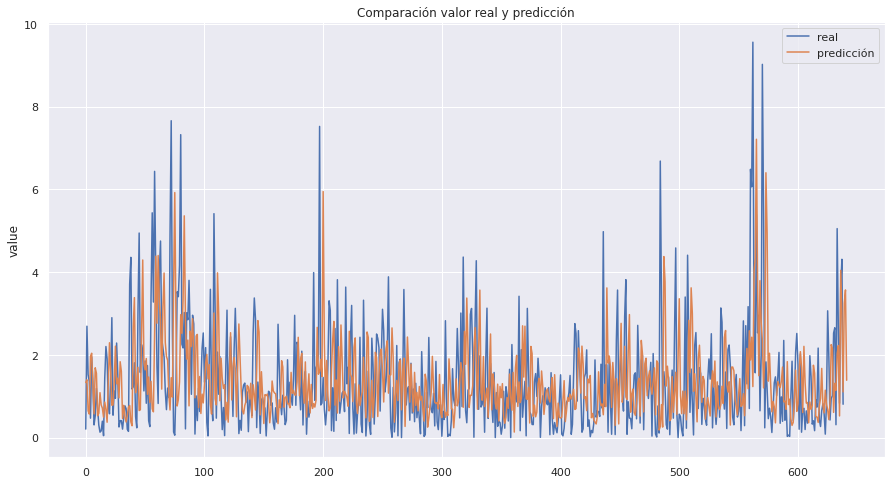

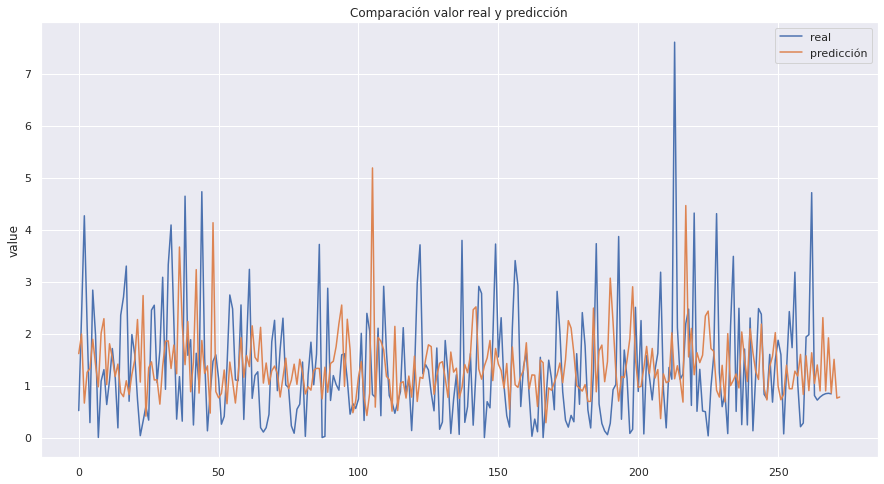

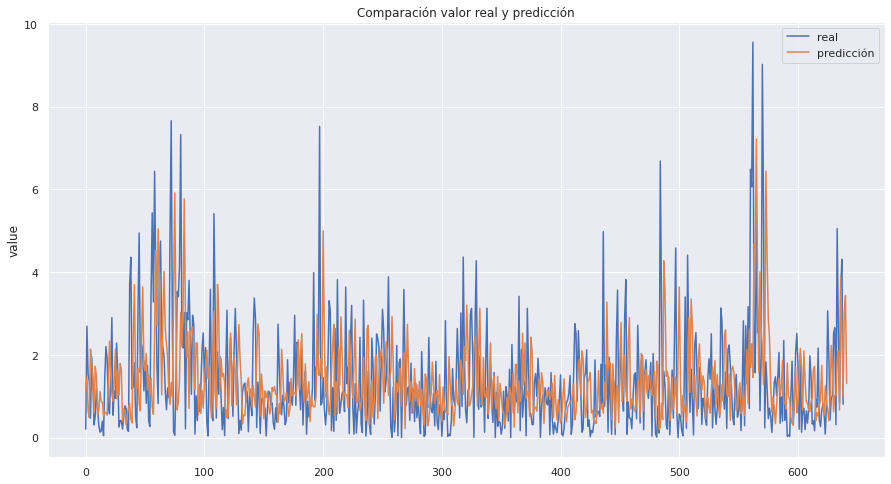

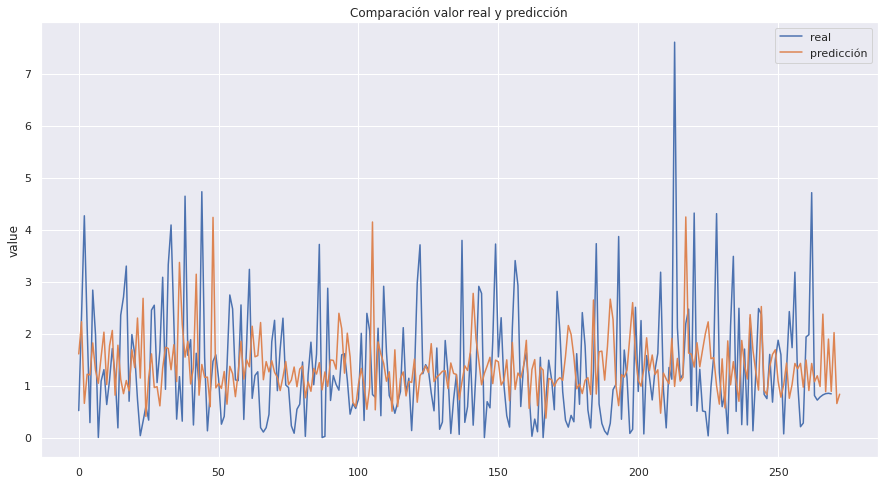

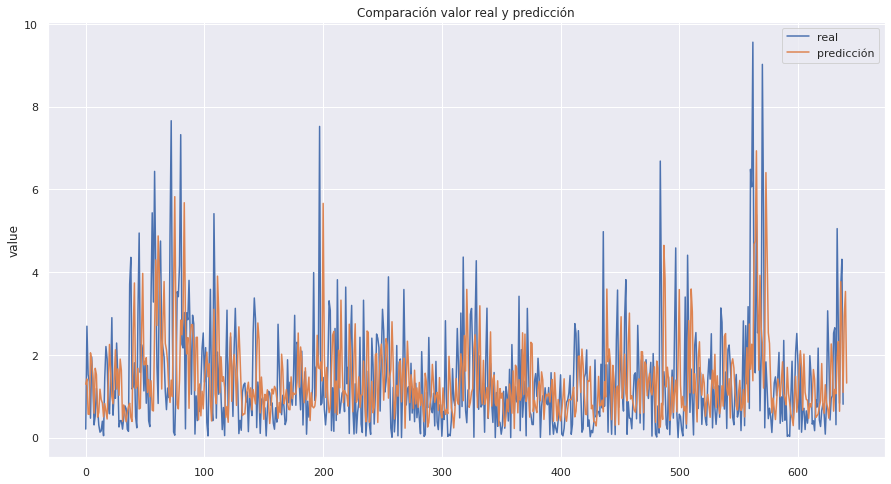

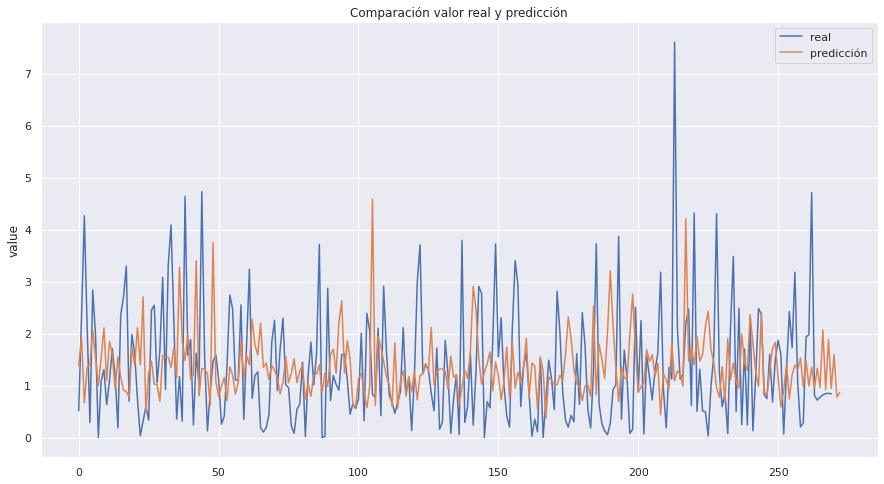

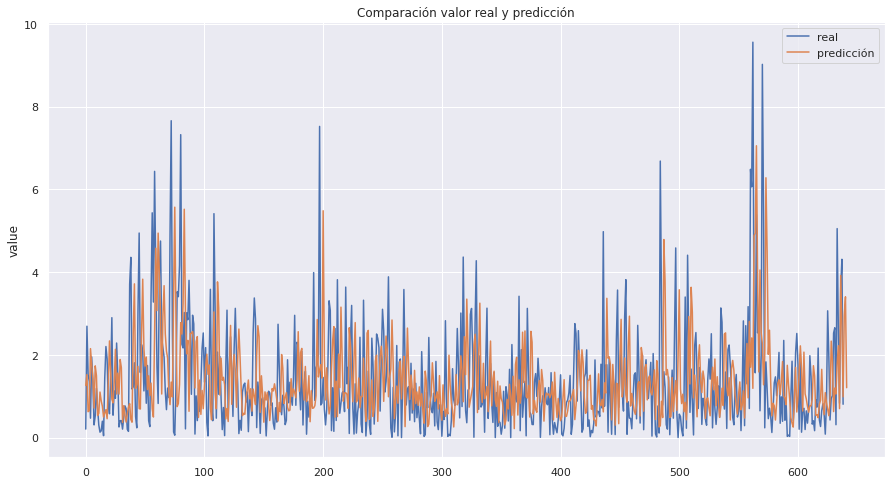

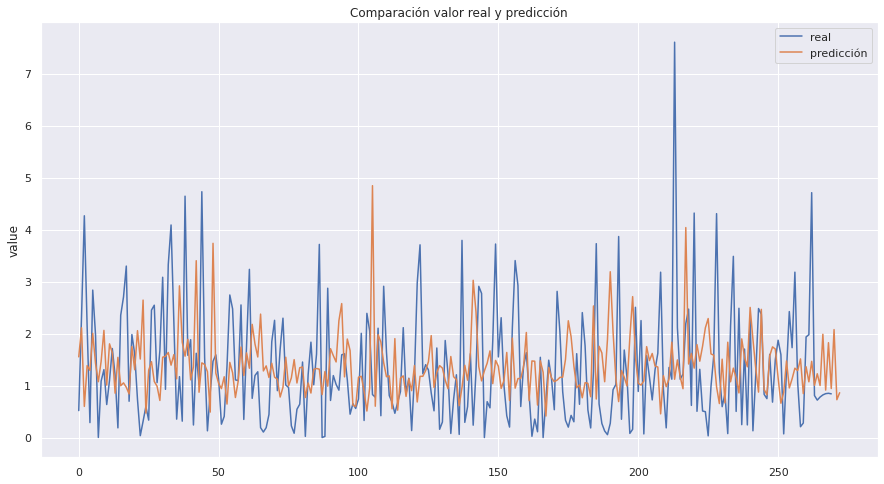

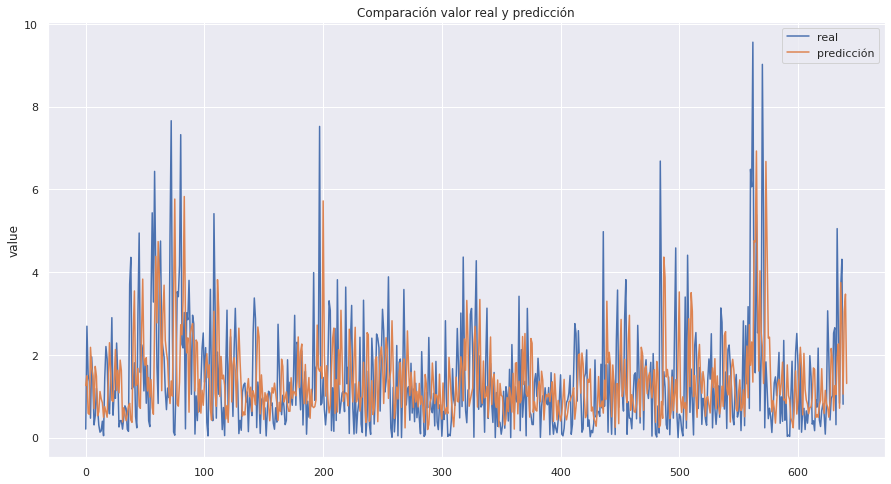

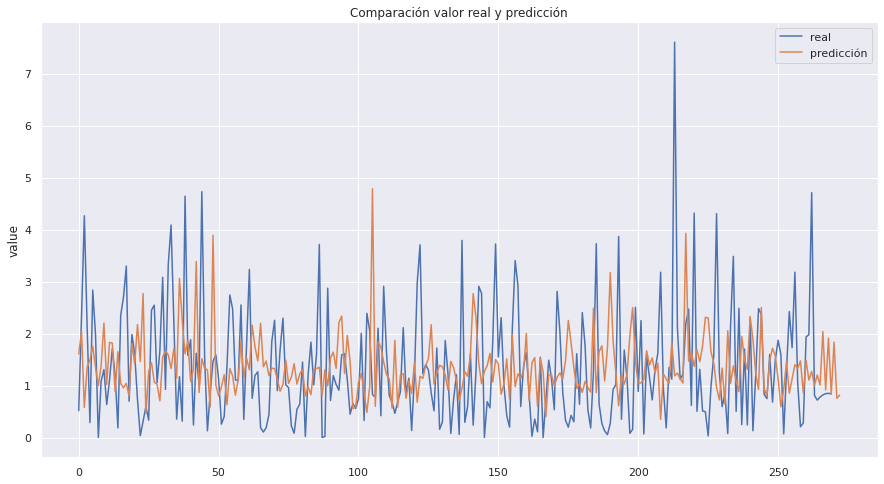

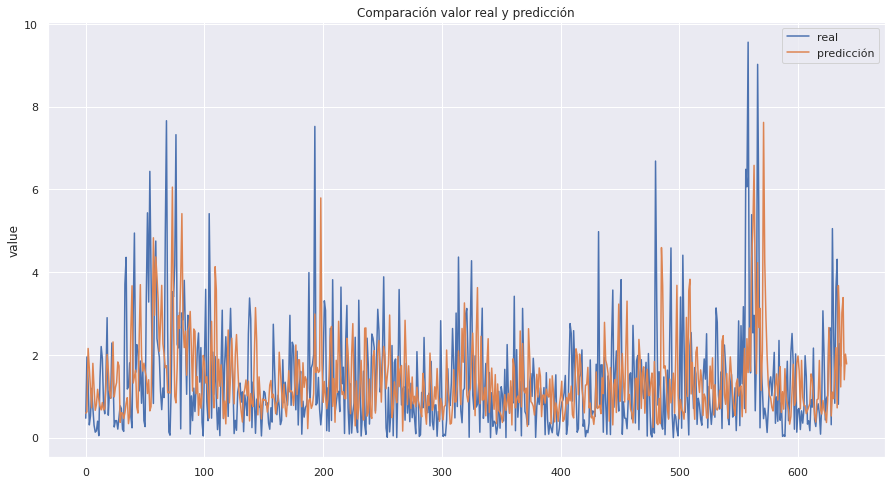

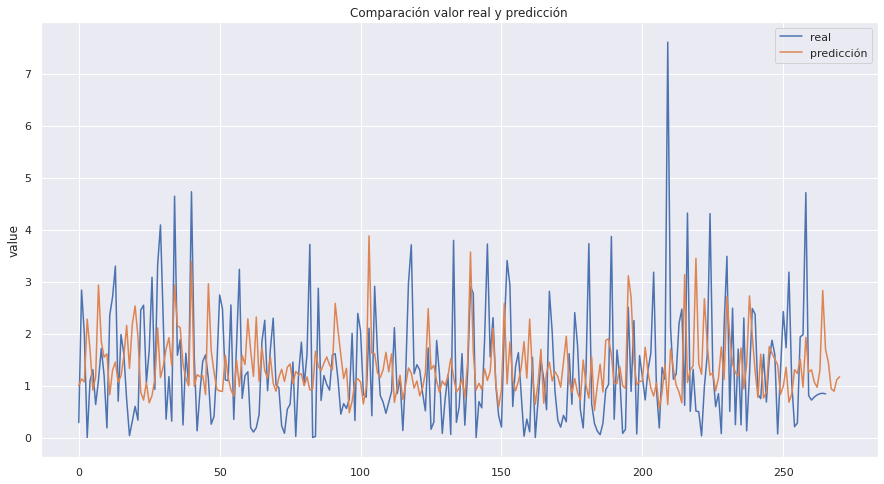

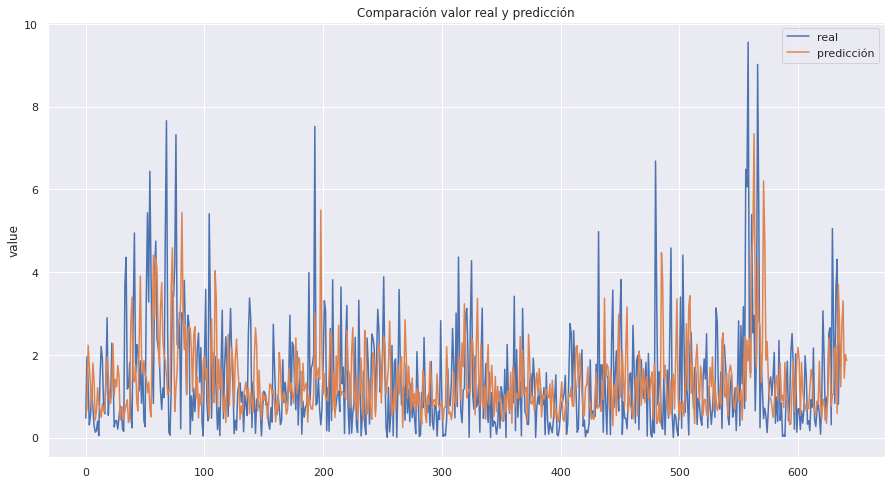

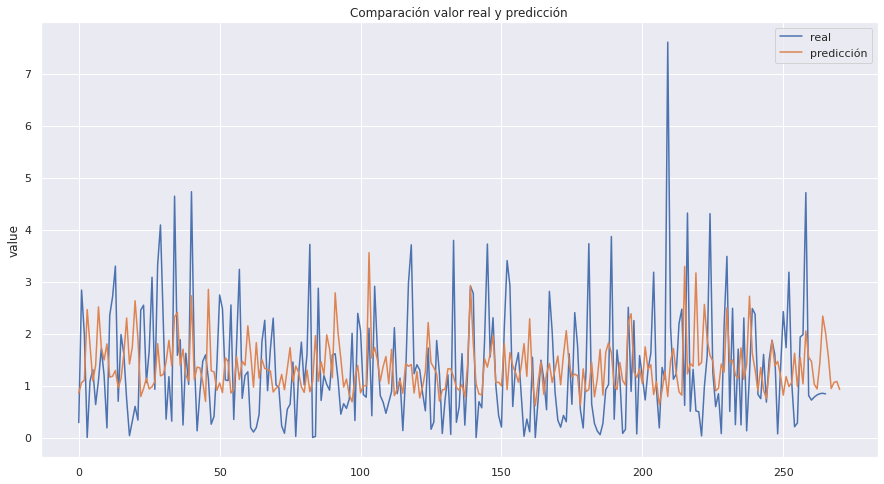

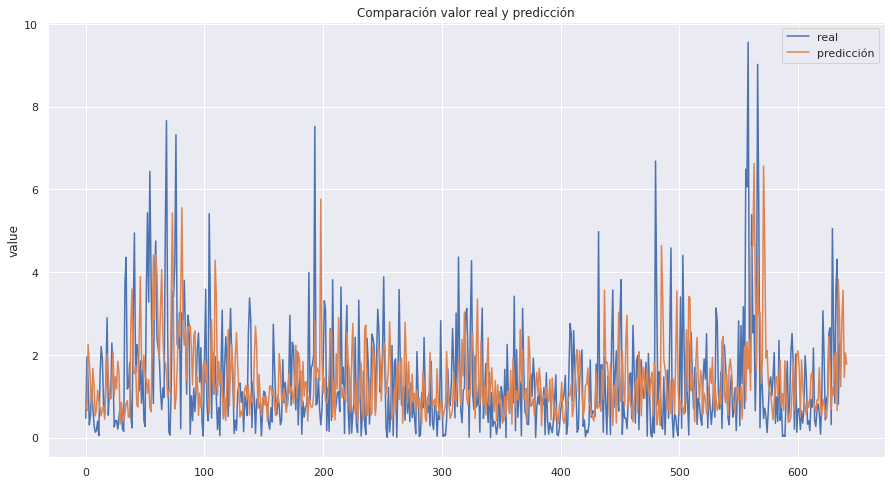

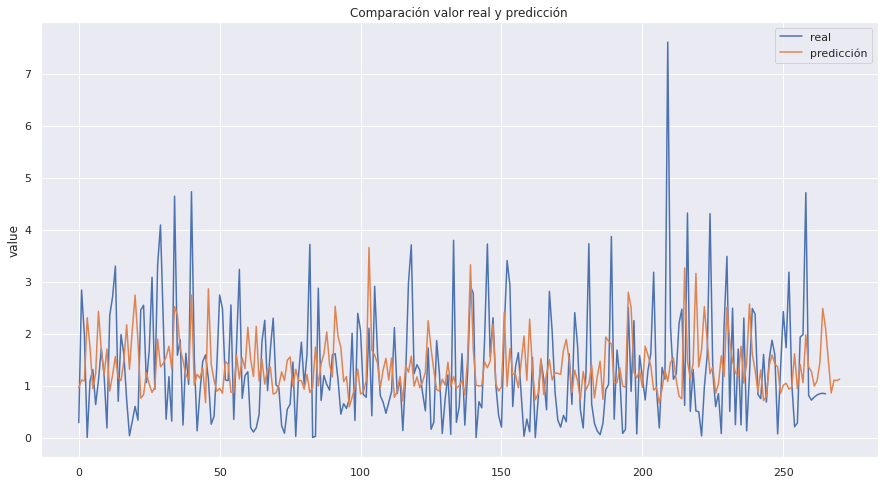

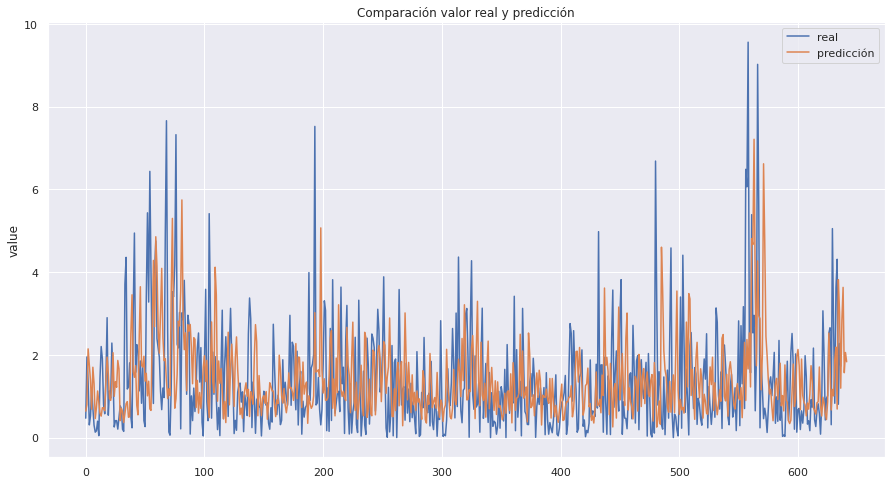

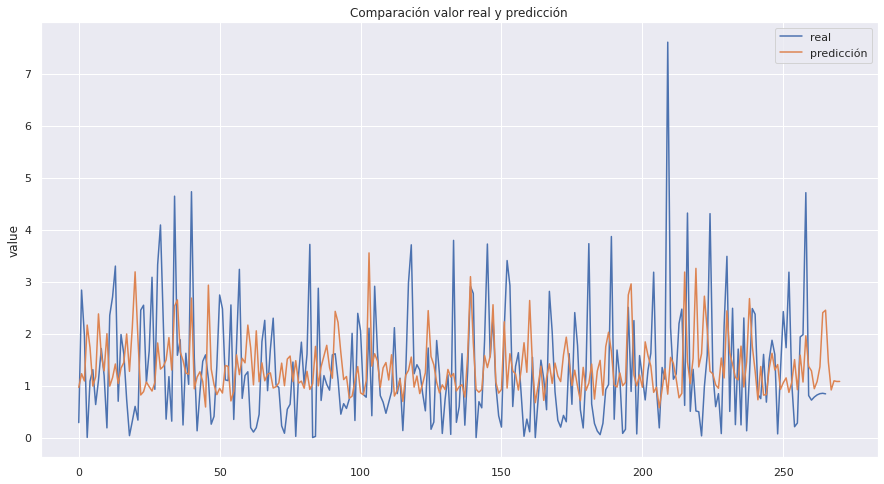

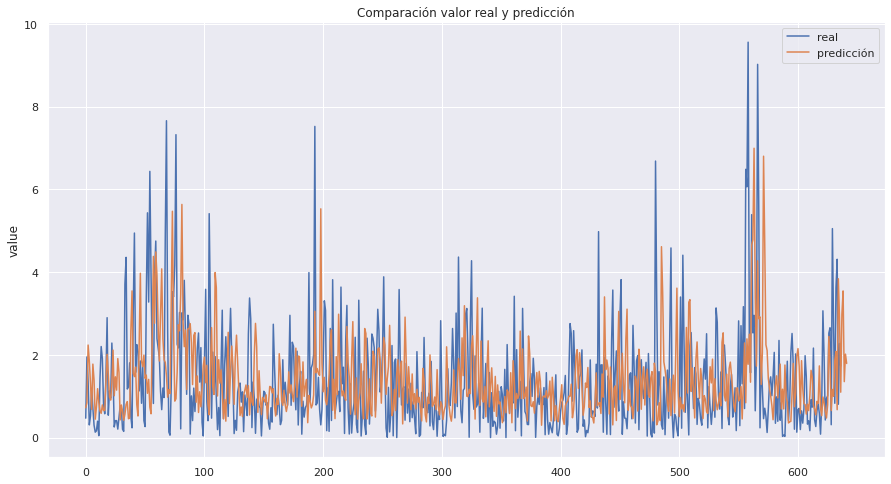

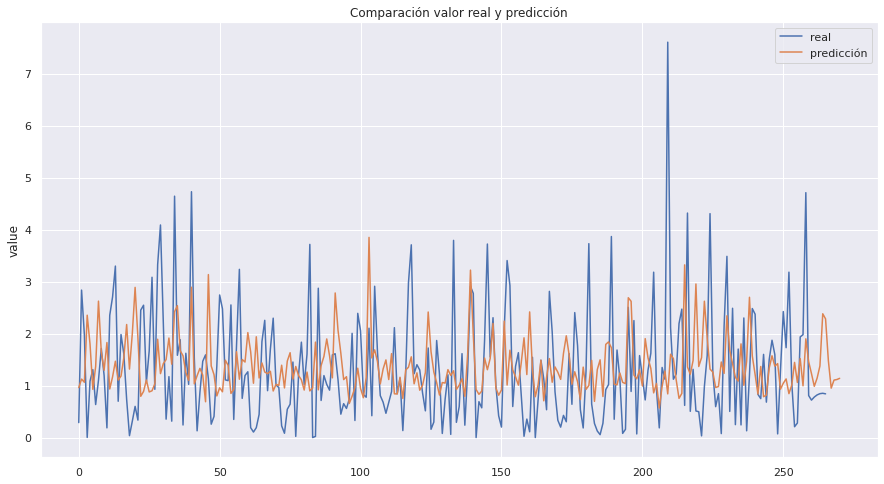

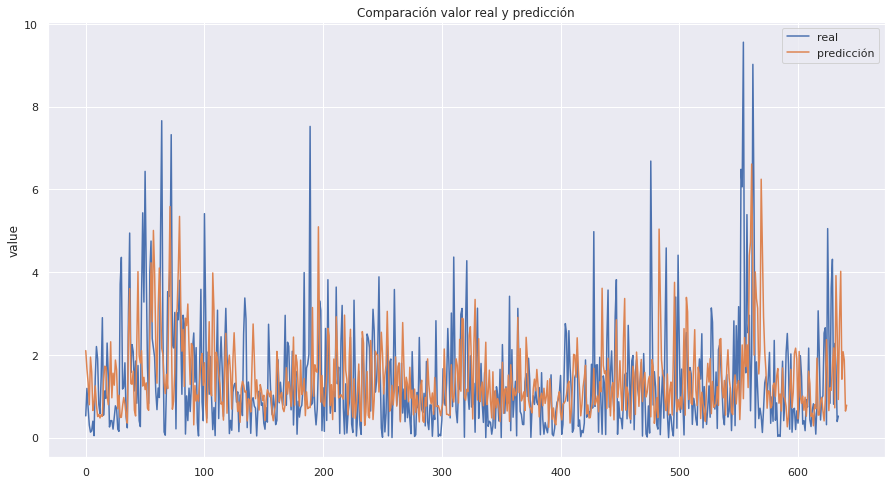

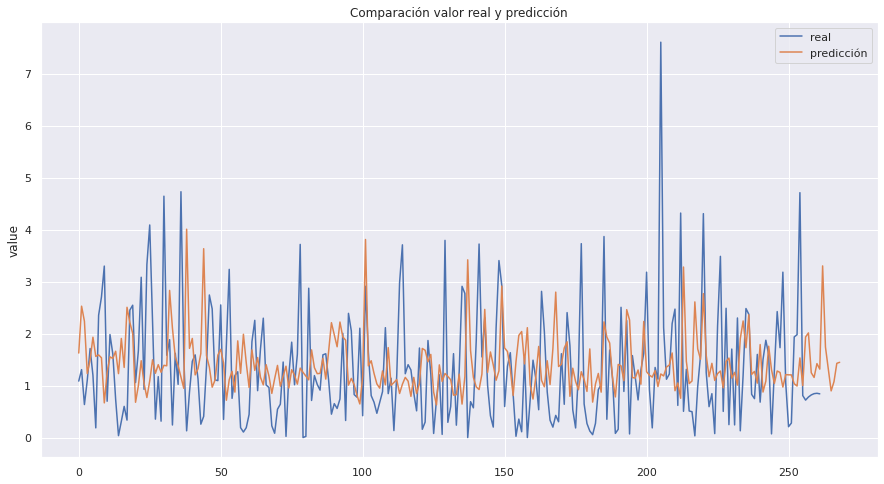

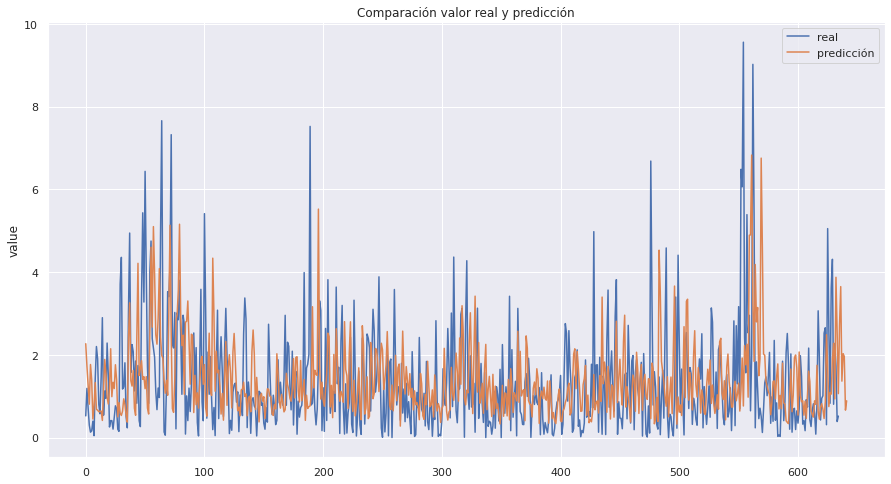

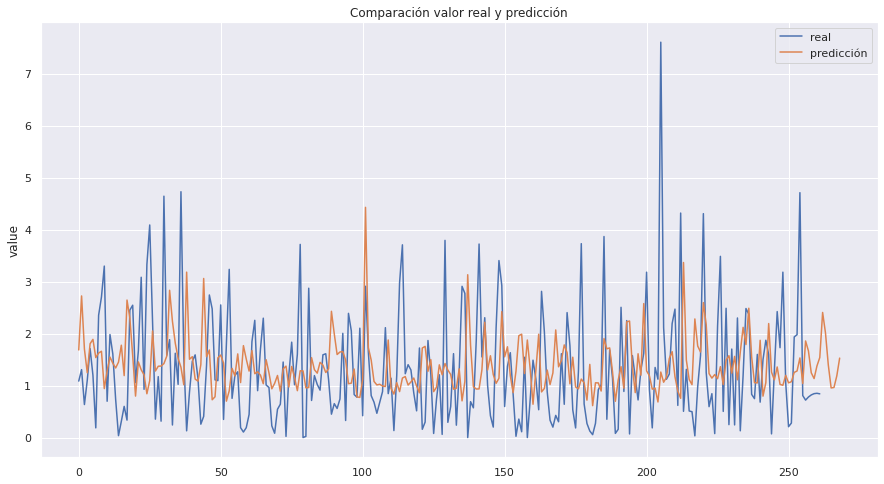

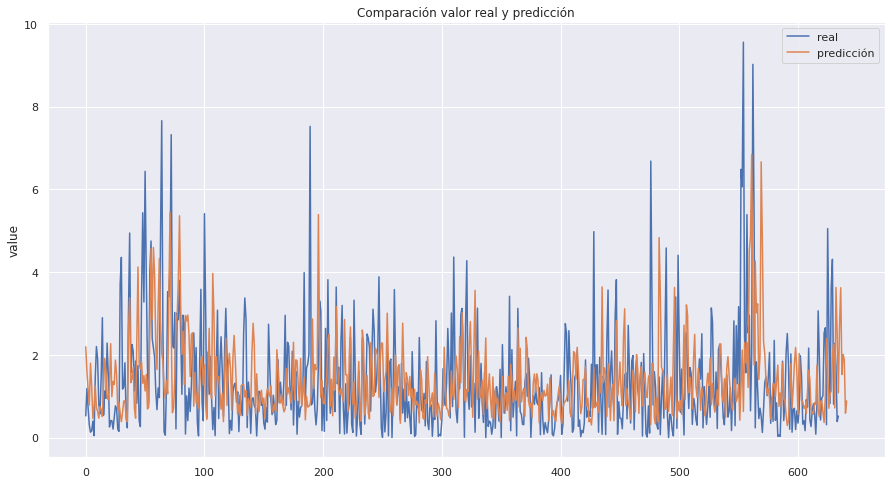

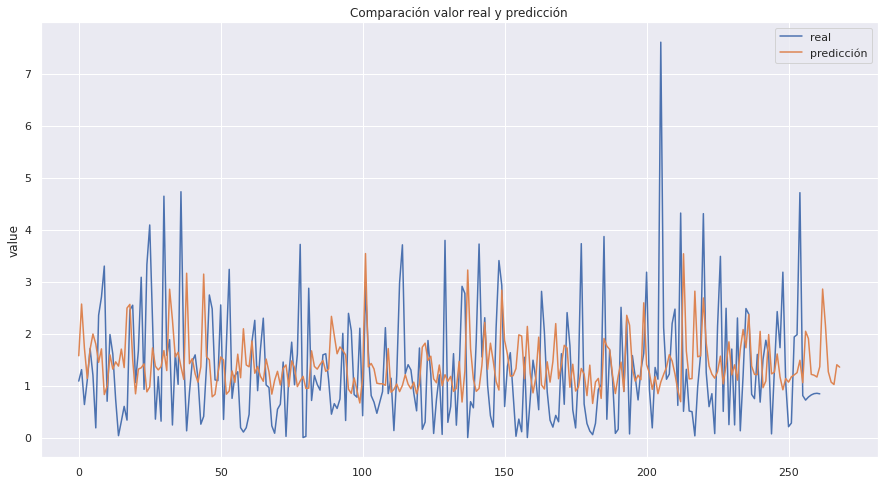

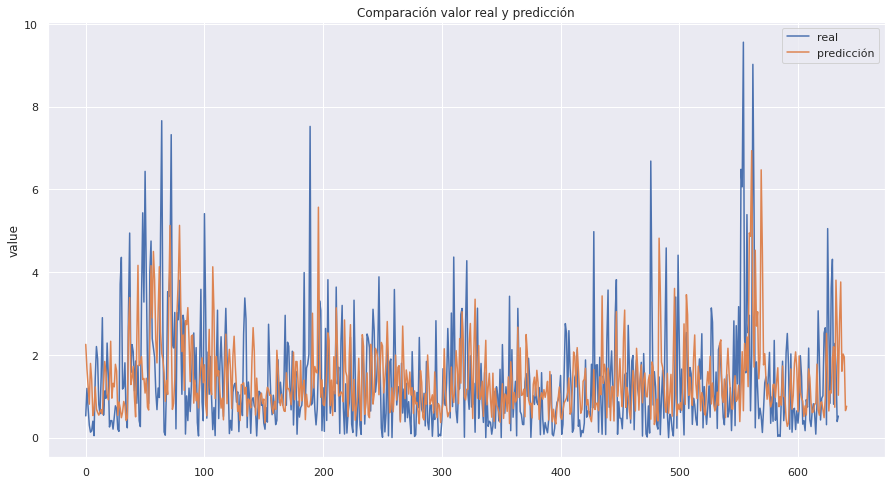

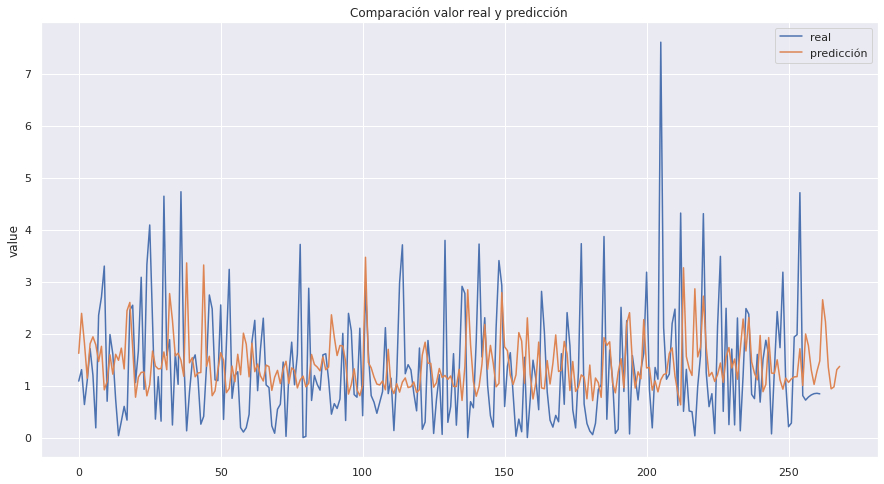

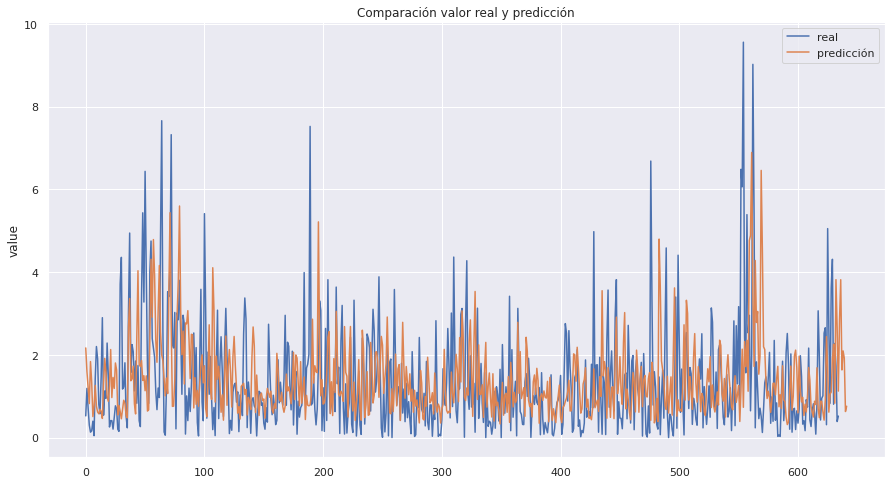

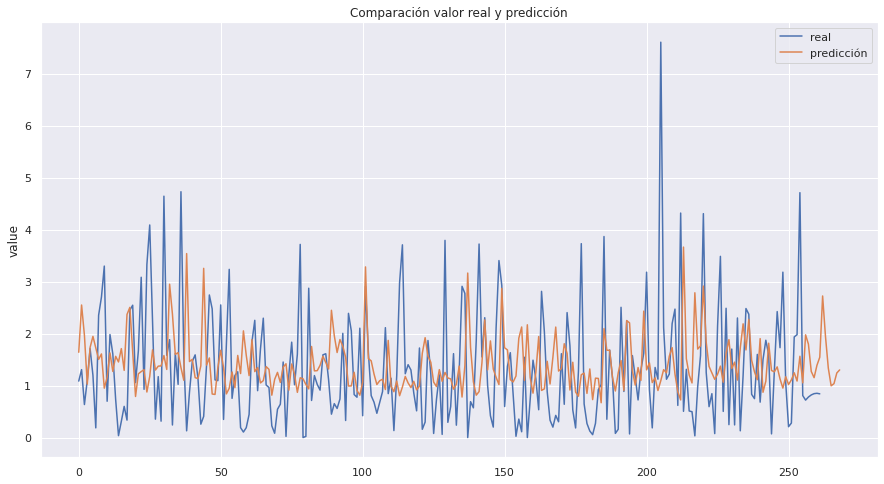

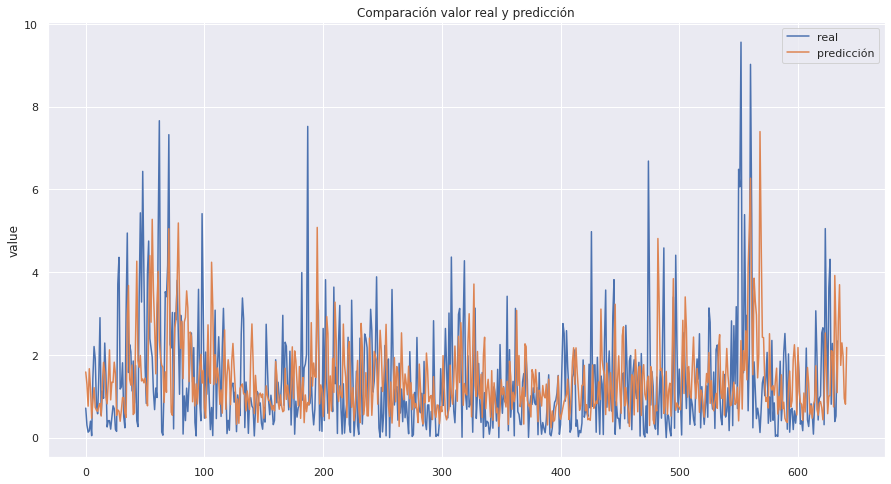

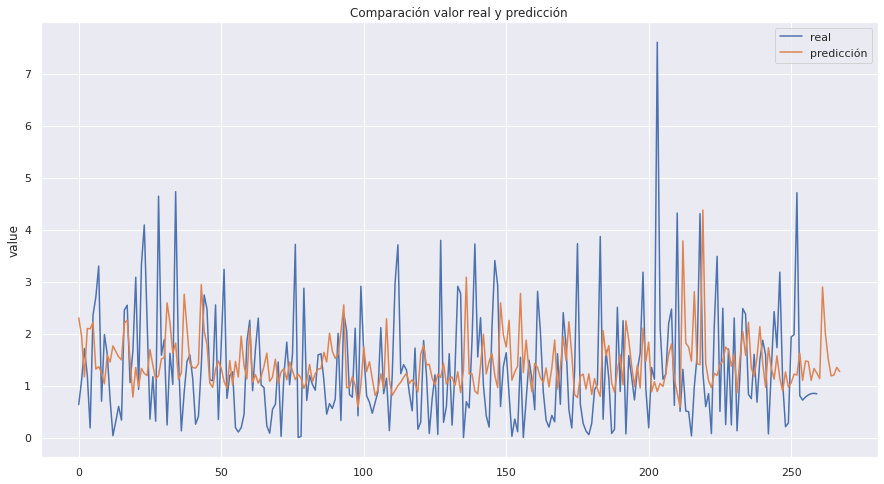

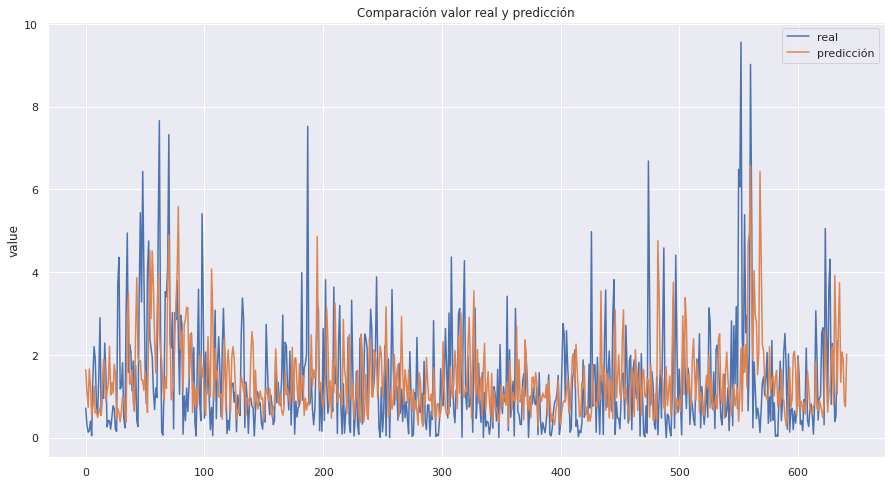

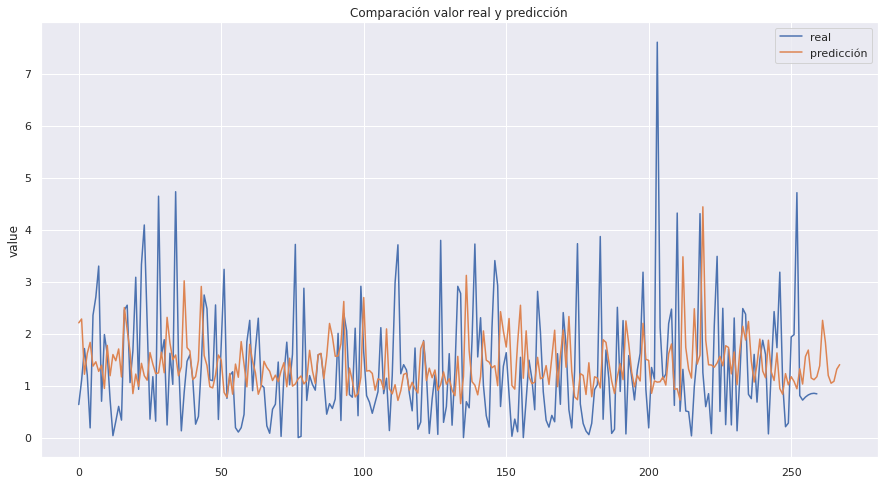

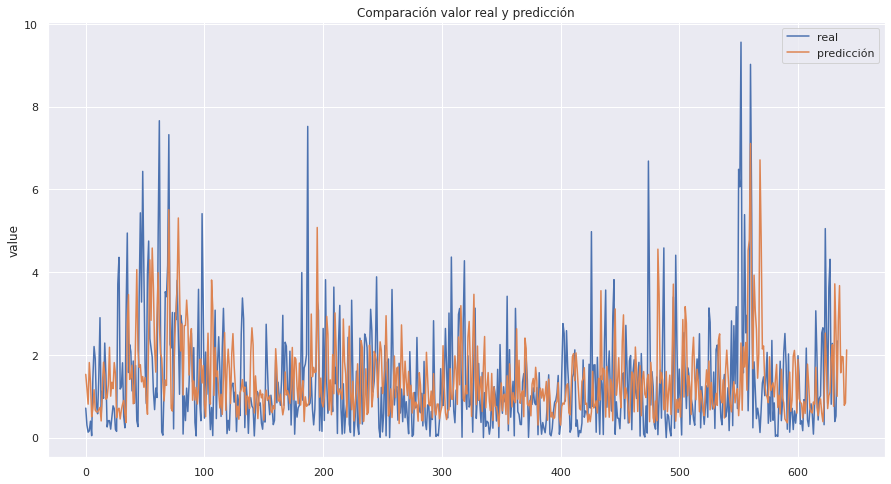

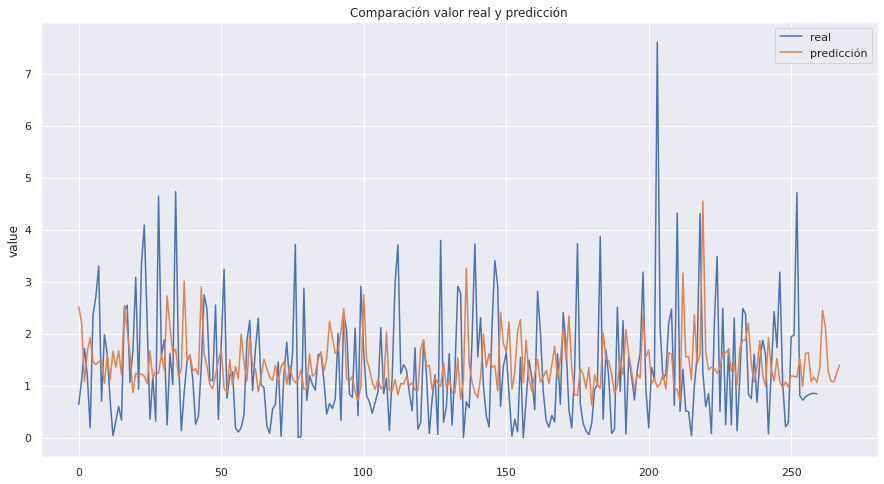

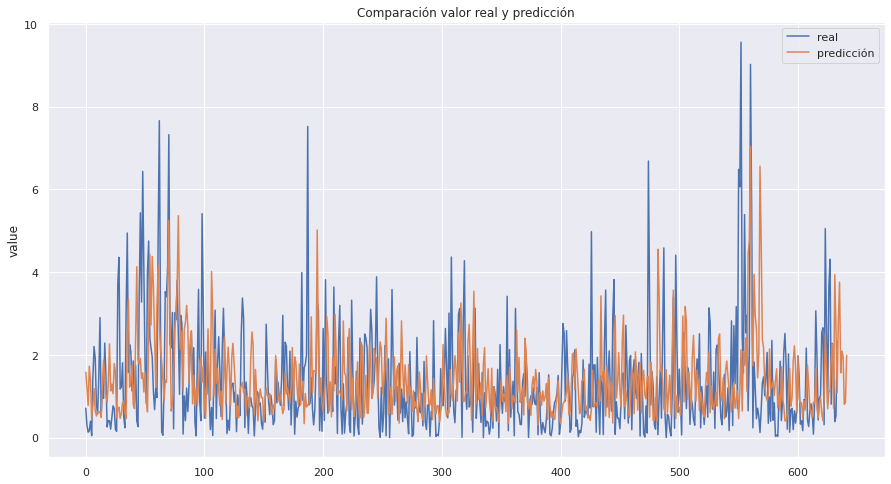

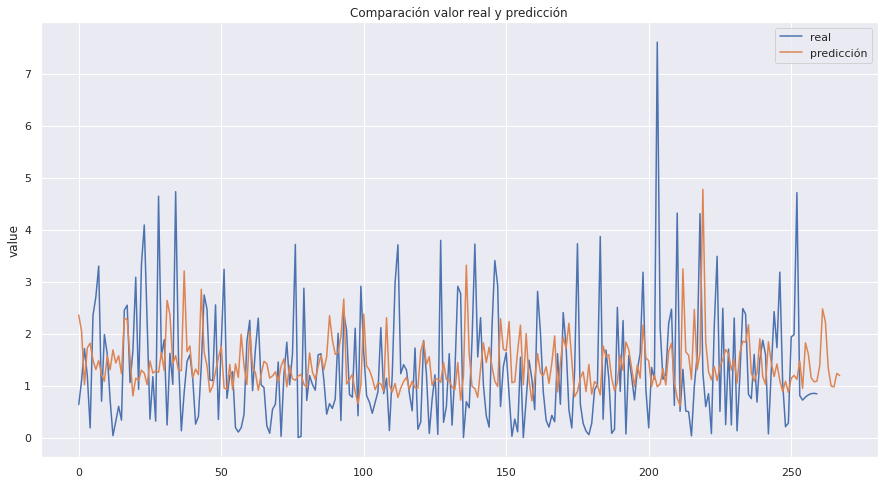

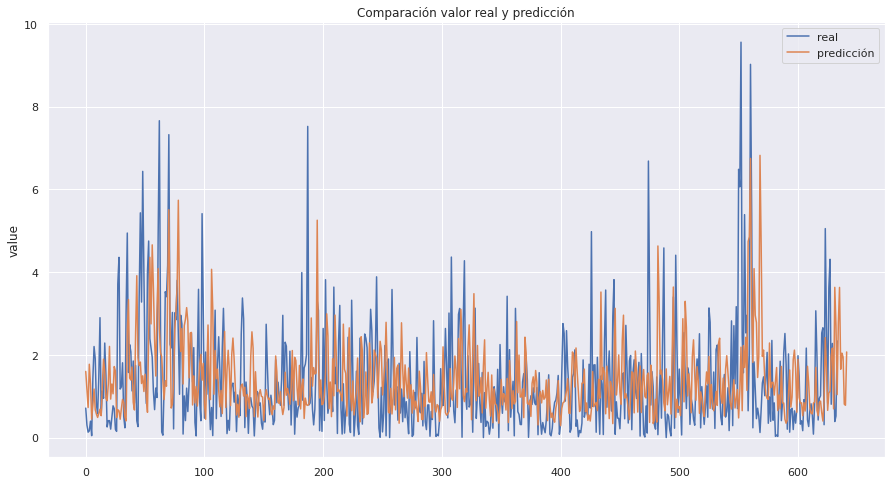

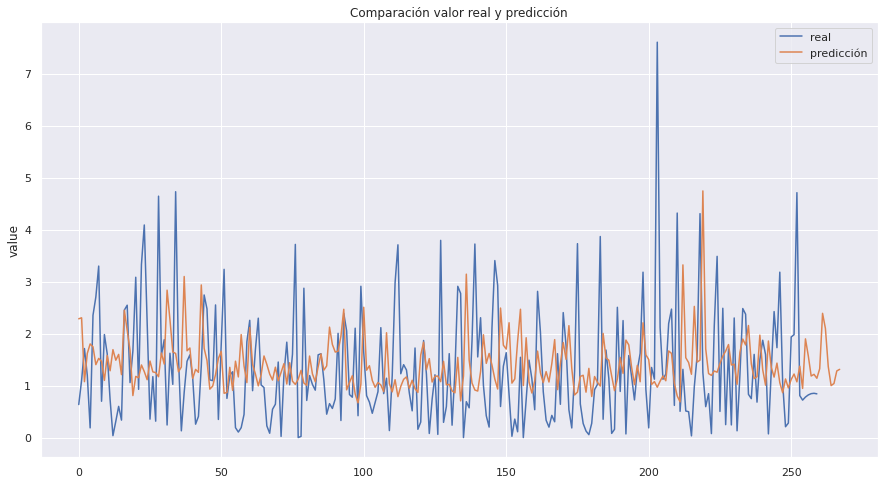

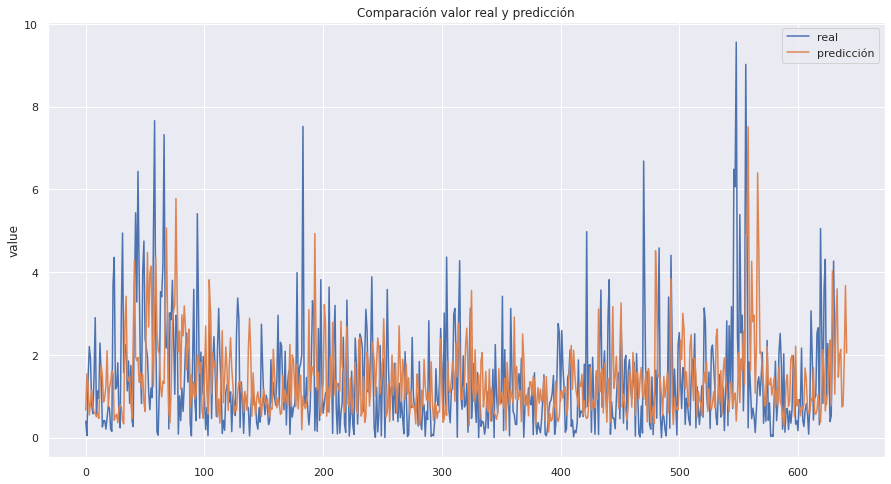

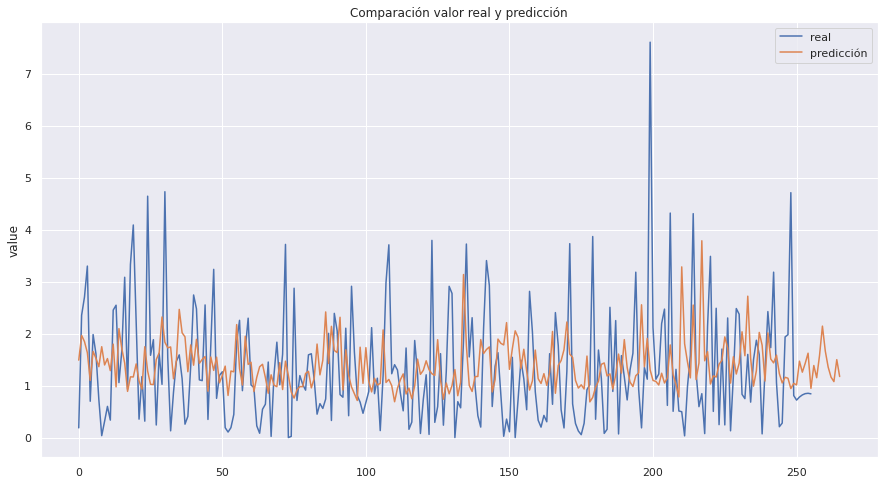

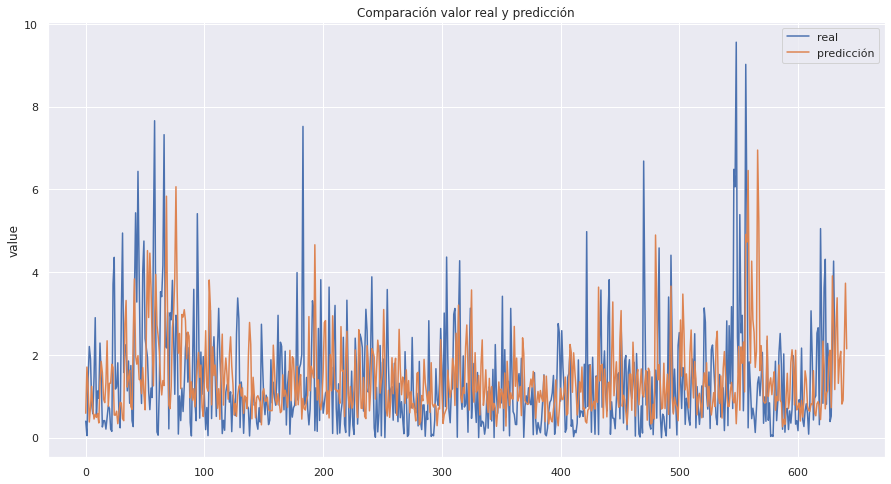

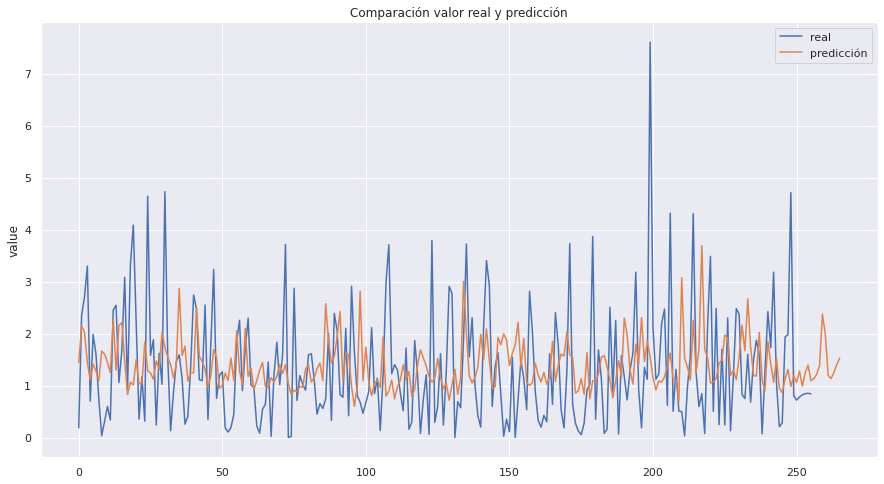

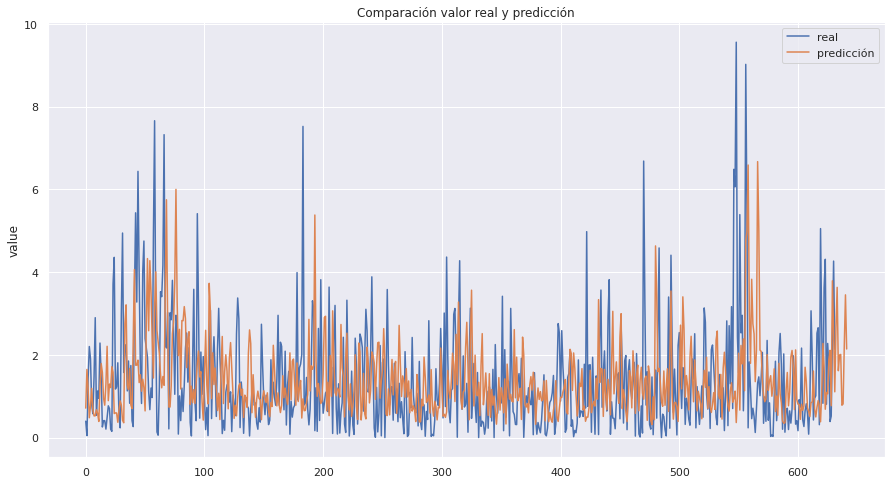

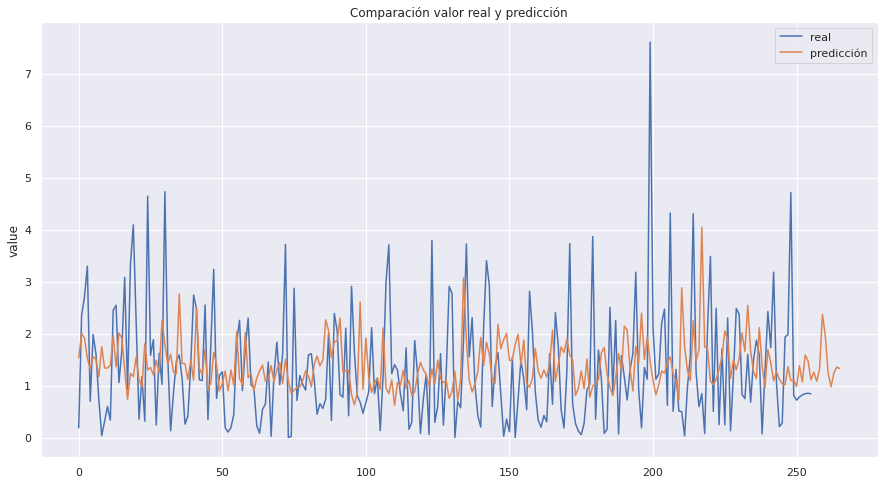

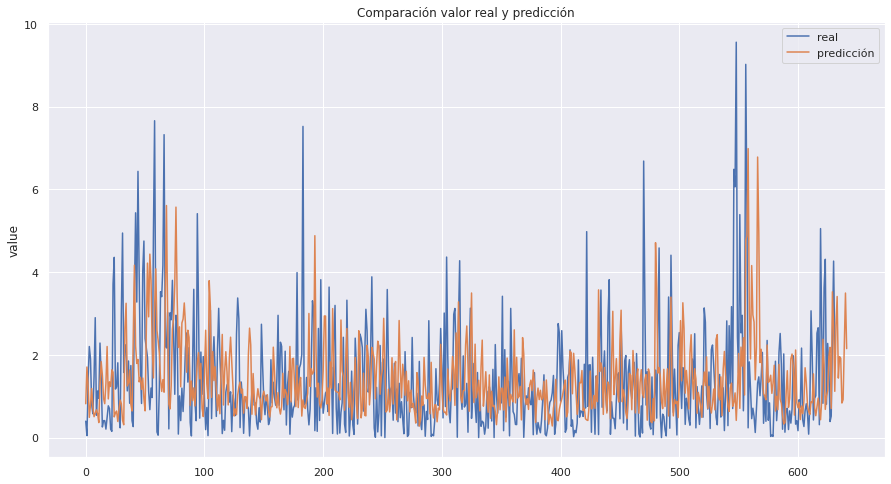

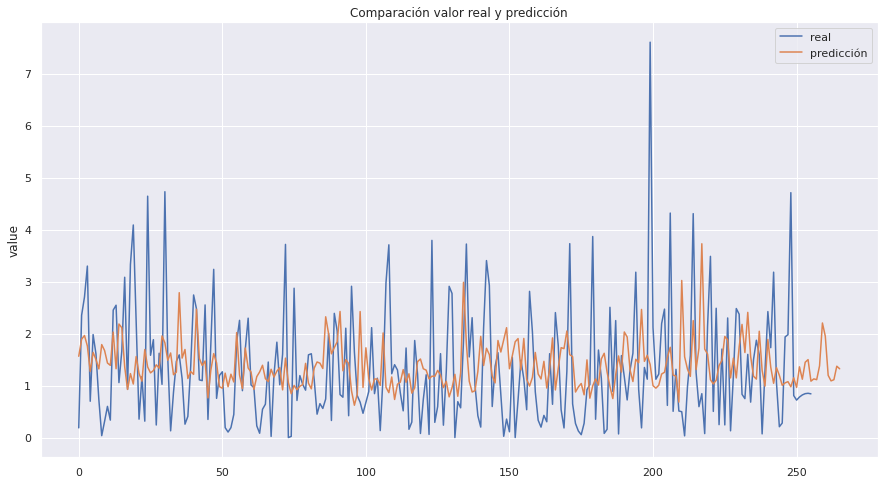

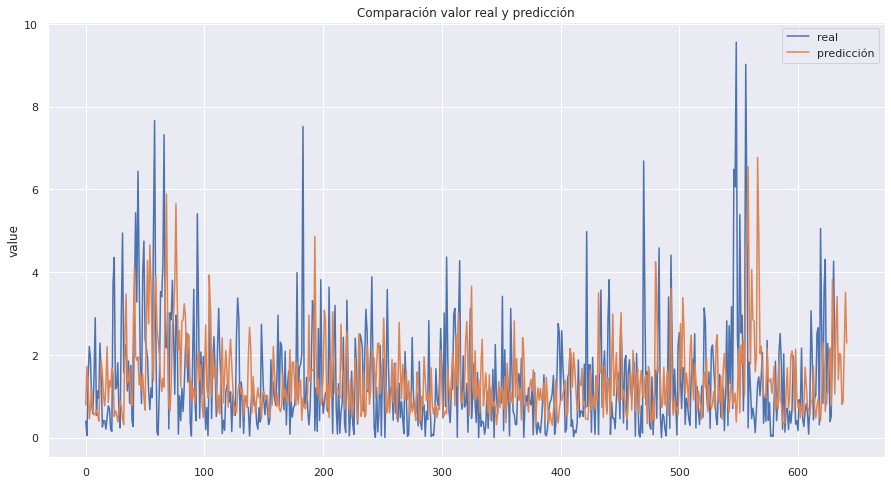

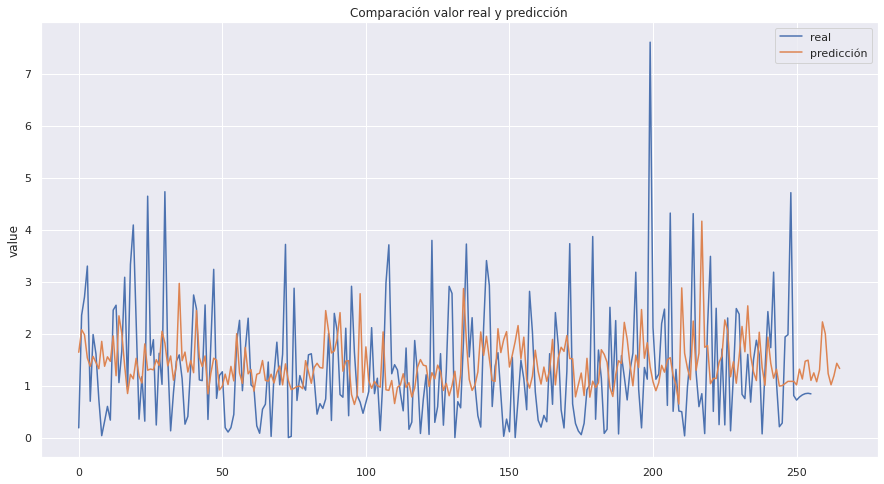

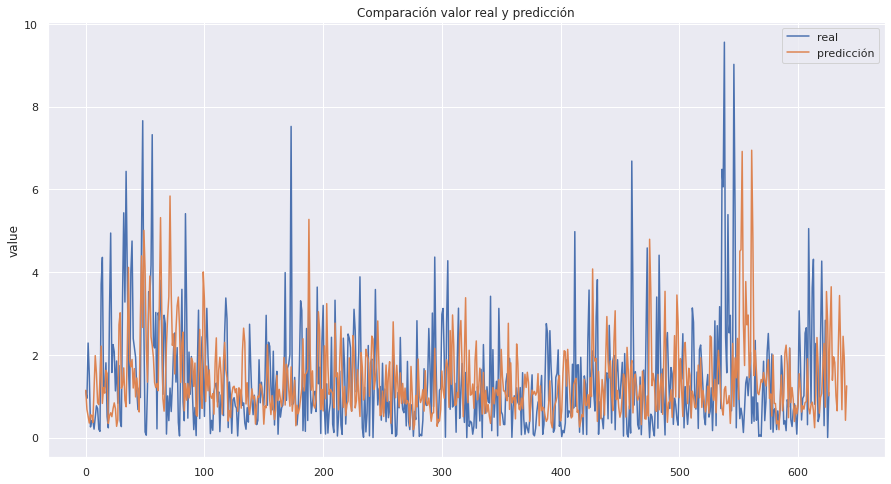

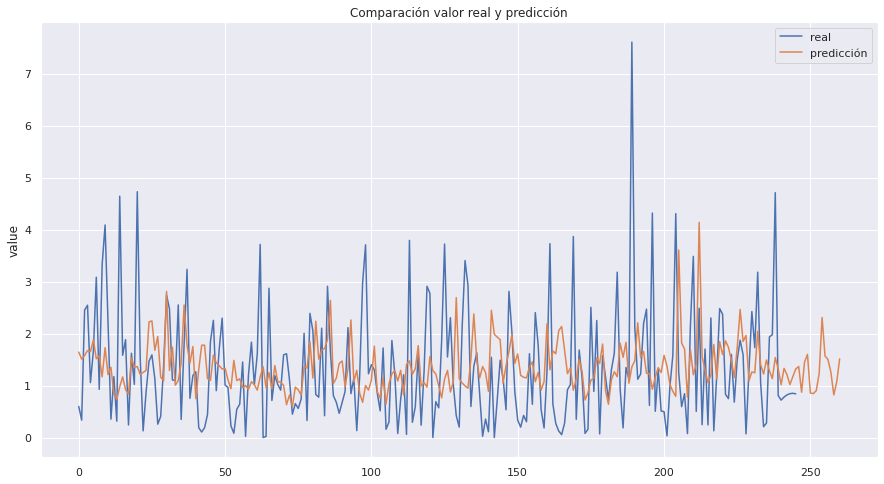

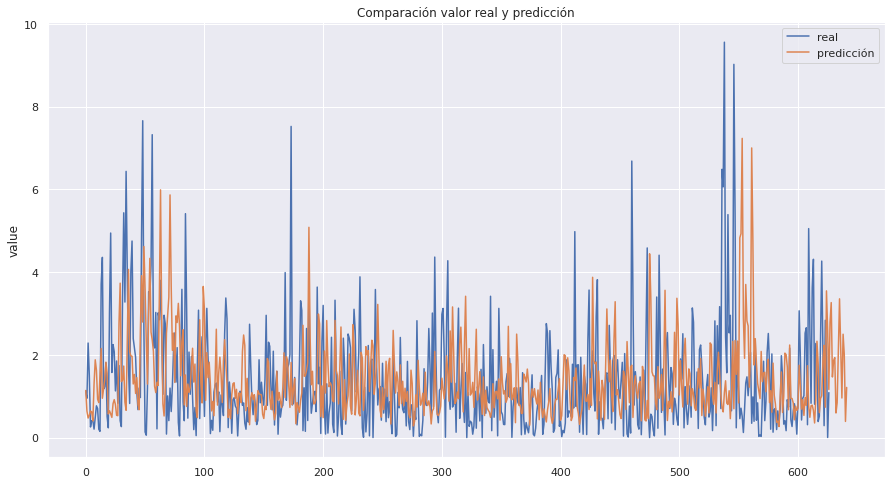

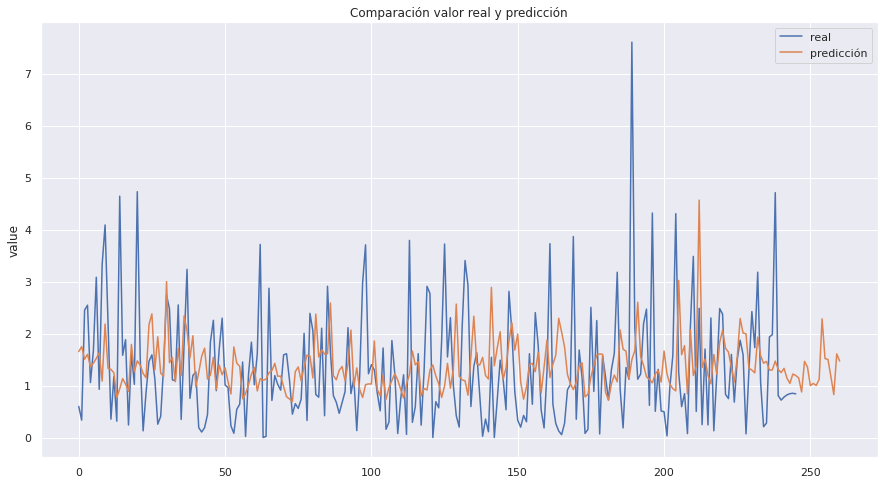

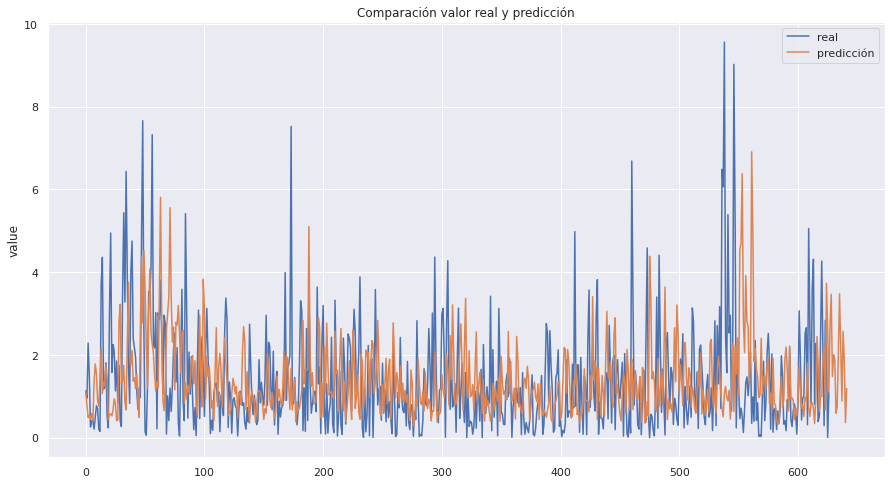

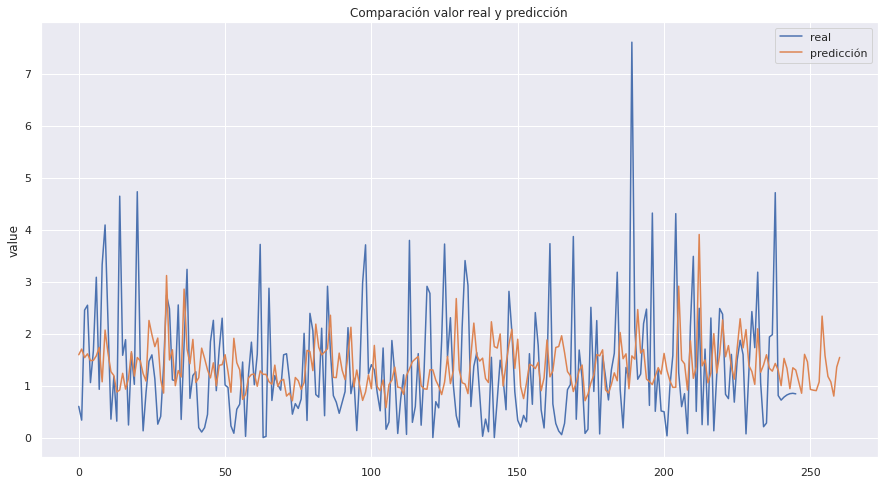

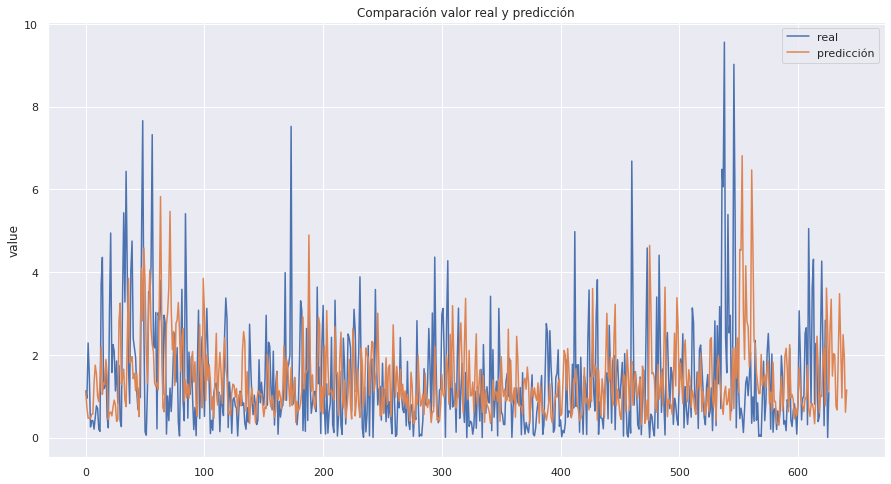

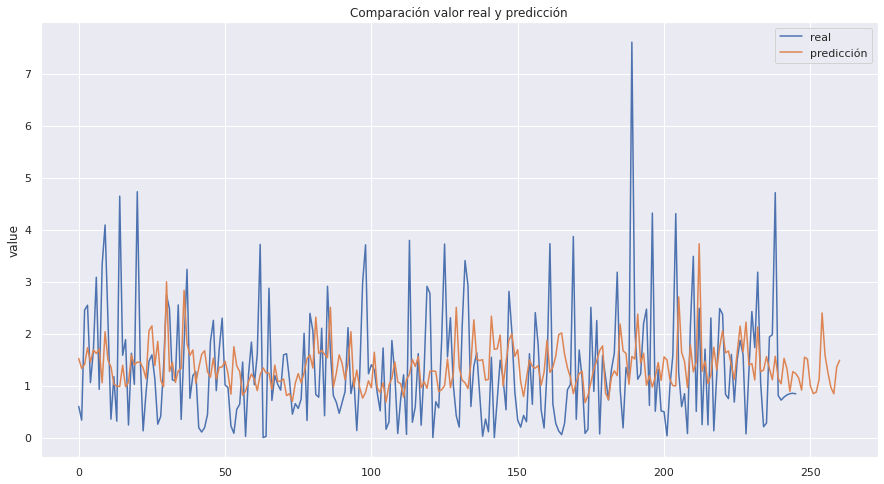

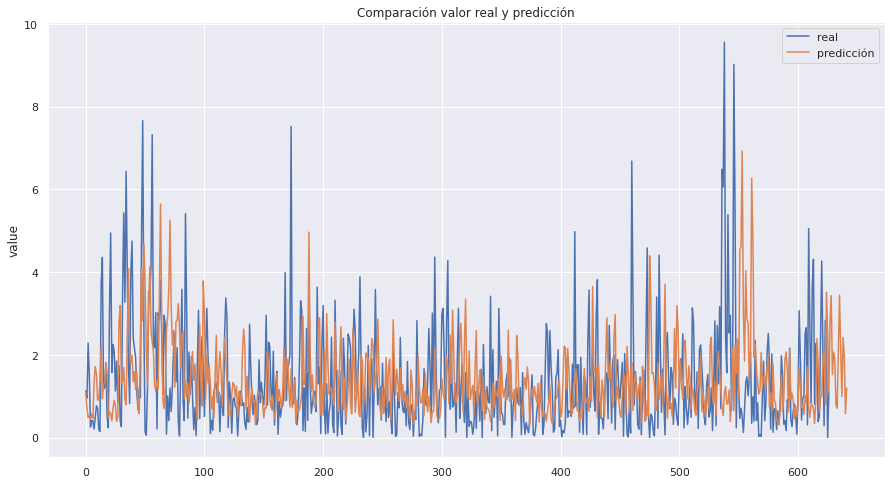

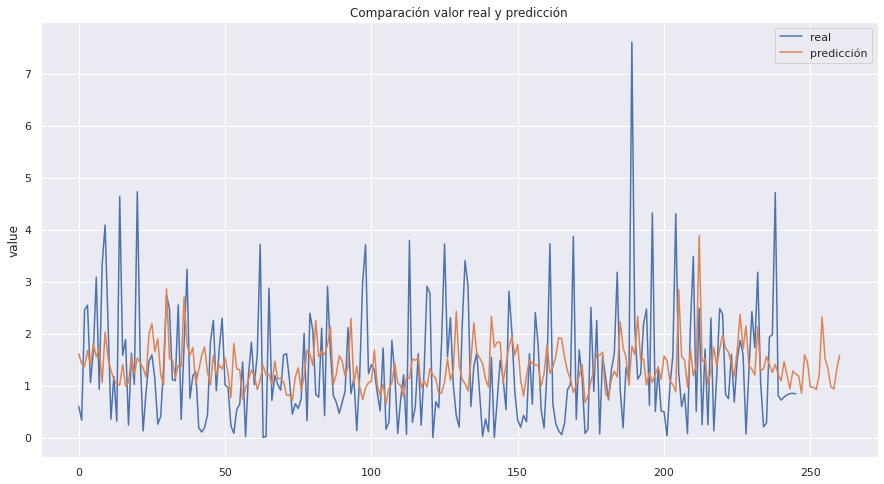

In [32]:
lags=[3,5,7,8,10,15]
n_estimators=n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)